In [1]:
# --- 1. Imports and Environment Setup ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.optim as optim

torch.set_default_dtype(torch.float64)


In [2]:
# --- 2. Constants and Normalization Factors ---
G = 5 # scaled gravitational constant
SCALE_X = 1e6           # distance in megameters
SCALE_V = 1e3           # velocity in km/s
SCALE_T = 1e4           # time in 10,000s


In [3]:
# --- 3. User Input ---
m1 = torch.tensor(1e6, dtype=torch.float32)
m2 = torch.tensor(1e5, dtype=torch.float32)
x1_0 = torch.tensor([0.0, 0.0]) / SCALE_X
x2_0 = torch.tensor([3.0e6, 0.0]) / SCALE_X
v1_0 = torch.tensor([0.0, 2.0e3]) / SCALE_V
v2_0 = torch.tensor([0.0, -2.0e3]) / SCALE_V
t_predict = 5000.0 / SCALE_T

In [4]:
# --- 4. Data Generator for Ground Truth ---
def generate_data(m1, m2, x1_0, x2_0, v1_0, v2_0, t_span, num_points=1000):
    def derivatives(t, y):
        x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
        r1 = np.array([x1, y1])
        r2 = np.array([x2, y2])
        r = np.linalg.norm(r2 - r1)
        a1 = G * m2 * (r2 - r1) / r**3
        a2 = G * m1 * (r1 - r2) / r**3
        return [vx1, vy1, vx2, vy2, *a1, *a2]

    y0 = [*(x1_0*SCALE_X), *(x2_0*SCALE_X), *(v1_0*SCALE_V), *(v2_0*SCALE_V)]
    t_eval = np.linspace(t_span[0], t_span[1], num_points)
    sol = solve_ivp(derivatives, t_span, y0, t_eval=t_eval)
    return sol.t, sol.y

In [5]:
# --- 5. Fourier Features ---
class FourierFeatures(nn.Module):
    def __init__(self, in_features, num_frequencies=10):
        super().__init__()
        self.freqs = 2 ** torch.arange(num_frequencies, dtype=torch.float32) * np.pi

    def forward(self, x):
        x_proj = x @ self.freqs.view(1, -1)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=1)

# --- 6. PINN Model ---
class TwoBodyPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fourier = FourierFeatures(1, 10)
        self.net = nn.Sequential(
            nn.Linear(20, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 8)
        )

    def forward(self, t):
        t_encoded = self.fourier(t)
        return self.net(t_encoded)



In [6]:
# --- 7. Loss Functions ---
def ode_residual(pred, t, m1, m2):
    x1 = pred[:, 0:2] * SCALE_X
    x2 = pred[:, 2:4] * SCALE_X
    v1 = pred[:, 4:6] * SCALE_V
    v2 = pred[:, 6:8] * SCALE_V

    dx1dt = torch.autograd.grad(x1, t, grad_outputs=torch.ones_like(x1), create_graph=True)[0]
    dx2dt = torch.autograd.grad(x2, t, grad_outputs=torch.ones_like(x2), create_graph=True)[0]
    dv1dt = torch.autograd.grad(v1, t, grad_outputs=torch.ones_like(v1), create_graph=True)[0]
    dv2dt = torch.autograd.grad(v2, t, grad_outputs=torch.ones_like(v2), create_graph=True)[0]

    r = torch.norm(x2 - x1, dim=1, keepdim=True).clamp(min=1e3)
    a1 = G * m2 * (x2 - x1) / r**3
    a2 = G * m1 * (x1 - x2) / r**3

    res1 = dv1dt - a1
    res2 = dv2dt - a2

    return (res1**2 + res2**2).mean()

In [7]:
model = TwoBodyPINN()
model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
model = model.float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

t_data, y_data = generate_data(m1, m2, x1_0, x2_0, v1_0, v2_0, (0, 10000), num_points=2000)
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1) / SCALE_T
y_true_tensor = torch.tensor(y_data.T, dtype=torch.float32)

# Normalize target values
y_true_tensor[:, 0:2] /= SCALE_X
y_true_tensor[:, 2:4] /= SCALE_X
y_true_tensor[:, 4:6] /= SCALE_V
y_true_tensor[:, 6:8] /= SCALE_V

for epoch in range(5000):
    model.train()
    optimizer.zero_grad()

    t_input = t_data_tensor.clone()
    t_input.requires_grad_()

    pred = model(t_input)

    # Losses
    loss_phys = ode_residual(pred, t_input, m1, m2)
    loss_ic = ((pred[0, 0:2] - x1_0)**2 + 
               (pred[0, 2:4] - x2_0)**2 +
               (pred[0, 4:6] - v1_0)**2 + 
               (pred[0, 6:8] - v2_0)**2).mean()

    loss_mae = (pred - y_true_tensor).abs().mean()
    l2_reg = sum((param**2).sum() for param in model.parameters())

    loss = 10.0 * loss_phys + 1.0 * loss_ic + 1.0 * loss_mae + 1e-6 * l2_reg
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}, Phys: {loss_phys.item():.4e}, IC: {loss_ic.item():.4e}, MAE: {loss_mae.item():.4e}")


Epoch 0, Loss: 2.2724e+12, Phys: 2.2724e+11, IC: 1.1584e+01, MAE: 3.4948e+00
Epoch 500, Loss: 1.4731e+07, Phys: 1.4731e+06, IC: 9.5326e+00, MAE: 3.5129e+00
Epoch 1000, Loss: 6.2796e+05, Phys: 6.2795e+04, IC: 7.4070e+00, MAE: 3.3745e+00
Epoch 1500, Loss: 4.1783e+04, Phys: 4.1776e+03, IC: 3.8043e+00, MAE: 3.1173e+00
Epoch 2000, Loss: 1.2106e+04, Phys: 1.2102e+03, IC: 1.7304e+00, MAE: 2.8874e+00
Epoch 2500, Loss: 1.6345e+03, Phys: 1.6308e+02, IC: 9.3525e-01, MAE: 2.7414e+00
Epoch 3000, Loss: 1.8595e+03, Phys: 1.8562e+02, IC: 6.1589e-01, MAE: 2.6694e+00
Epoch 3500, Loss: 6.5301e+02, Phys: 6.4993e+01, IC: 4.4358e-01, MAE: 2.6351e+00
Epoch 4000, Loss: 1.0053e+02, Phys: 9.7566e+00, IC: 3.5497e-01, MAE: 2.6127e+00
Epoch 4500, Loss: 4.9051e+01, Phys: 4.6159e+00, IC: 2.9575e-01, MAE: 2.5959e+00


In [8]:
with torch.no_grad():
    t_val = torch.tensor([[t_predict]], dtype=torch.float32)
    pred_val = model(t_val)
    x1_pred = pred_val[:, 0:2] * SCALE_X
    x2_pred = pred_val[:, 2:4] * SCALE_X

    print(f"\nPredicted position at t = {t_predict * SCALE_T:.0f}s")
    print("x1:", x1_pred.numpy())
    print("x2:", x2_pred.numpy())

    # Compare full trajectory MAE
    y_pred_full = model(t_data_tensor)
    x1_pred_full = y_pred_full[:, 0:2] * SCALE_X
    x2_pred_full = y_pred_full[:, 2:4] * SCALE_X
    v1_pred_full = y_pred_full[:, 4:6] * SCALE_V
    v2_pred_full = y_pred_full[:, 6:8] * SCALE_V

    mae_x1 = (x1_pred_full - y_true_tensor[:, 0:2]).abs().mean()
    mae_x2 = (x2_pred_full - y_true_tensor[:, 2:4]).abs().mean()
    mae_v1 = (v1_pred_full - y_true_tensor[:, 4:6]).abs().mean()
    mae_v2 = (v2_pred_full - y_true_tensor[:, 6:8]).abs().mean()

    print("\n--- MAE Compared to ODE Solver ---")
    print(f"Position MAE - Body 1: {mae_x1.item():.4f} m, Body 2: {mae_x2.item():.4f} m")
    print(f"Velocity MAE - Body 1: {mae_v1.item():.4f} m/s, Body 2: {mae_v2.item():.4f} m/s")



Predicted position at t = 5000s
x1: [[-11427.343 238838.89 ]]
x2: [[2998937.5  -146080.84]]

--- MAE Compared to ODE Solver ---
Position MAE - Body 1: 112926.4297 m, Body 2: 1574413.5000 m
Velocity MAE - Body 1: 813.1144 m/s, Body 2: 727.1803 m/s


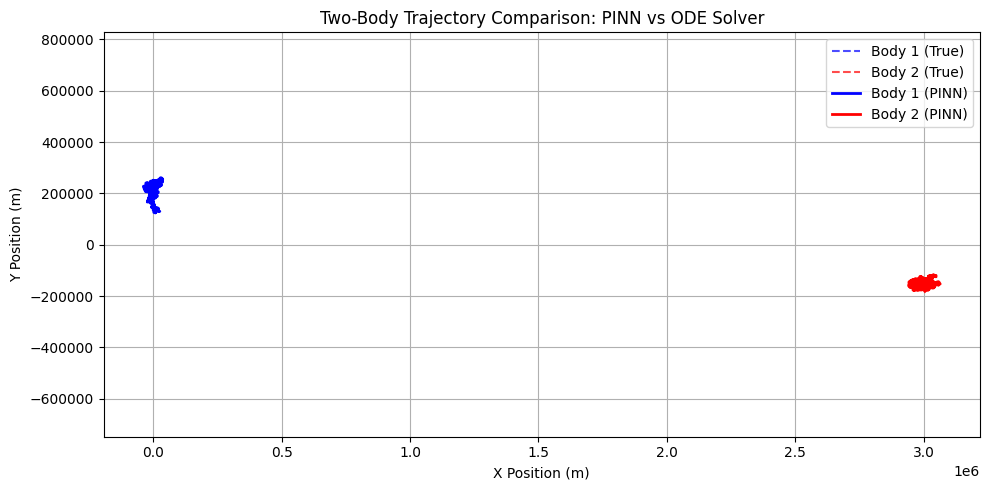

In [9]:
# --- 9. Plot Trajectories ---
plt.figure(figsize=(10, 5))
plt.plot(y_true_tensor[:, 0], y_true_tensor[:, 1], 'b--', label='Body 1 (True)', alpha=0.7)
plt.plot(y_true_tensor[:, 2], y_true_tensor[:, 3], 'r--', label='Body 2 (True)', alpha=0.7)

plt.plot(x1_pred_full[:, 0], x1_pred_full[:, 1], 'b-', label='Body 1 (PINN)', linewidth=2)
plt.plot(x2_pred_full[:, 0], x2_pred_full[:, 1], 'r-', label='Body 2 (PINN)', linewidth=2)

plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Two-Body Trajectory Comparison: PINN vs ODE Solver')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()
